In [1]:
using Pkg
Pkg.activate("..")  #one level up, where Project.toml lives
Pkg.instantiate()   #download/install anything missing
# Pkg.status();

  Activating project at `~/Documents/repos/JuliaExploreHRM`


In [2]:
include(joinpath(@__DIR__, "..", "hrm_common.jl"))

testo (generic function with 1 method)

In [3]:
using Plots, Test

In [44]:
#data generator
# y = w^T x + 0.1 * ||x||^2 + eps, where ( eps is N(0, 0.01) )

struct ToyGen
    w::Vector{Float32}
end

function ToyGen(d_in::Int; seed::Int=123)
    Random.seed!(seed)
    w = randn(Float32, d_in)
    return ToyGen(w)
end

#returns (x, y) with shapes (d_in, batch), (1, batch)
function sample!(gen::ToyGen, batch::Int)
    d = length(gen.w)
    x = randn(Float32, d, batch)
    # linear part
    y_lin = gen.w' * x      # (1, batch)
    # small quadratic interaction
    y_quad = 0.1f0 .* sum(abs2, x; dims=1)    # (1, batch)
    # noise
    eps = 0.01f0 .* randn(Float32, 1, batch)
    y = Float32.(y_lin .+ y_quad .+ eps)
    return x, y
end

sample! (generic function with 1 method)

In [45]:
"""
    quantize_to_tokens(x; num_tokens::Int, lo::Real, hi::Real)

Uniformly bins each element of x in [lo, hi] into 1..num_tokens.
Clamps values outside [lo, hi] to the nearest edge bin.
"""
LO = -3.0
HI =  3.0

function quantize_to_tokens(x; num_tokens::Int, lo::Real, hi::Real)
    if num_tokens ≤ 0
        error("quantize_to_tokens called with num_tokens <= 0; use raw floats instead.")
    end
    @assert num_tokens ≥ 2
    xn = @. clamp((x - lo) / (hi - lo + eps(eltype(x))), 0, 1)
    ids = floor.(Int, xn * (num_tokens - 1)) .+ 1
    return ids
end

quantize_to_tokens (generic function with 1 method)

In [46]:
CFG = (
    d_in   = 16,
    d_hid  = 64,
    d_out  = 1,
    N      = 2,
    T      = 3,
    M      = 1,
    batch  = 64,
    lr     = 1e-3,
    steps  = 300,
    seed   = 42,

    # input encoding
    num_tokens = 0,     # set >0 to use embeddings with IDs; 0 = raw float encoder
    d_embed    = 32,

    # transformer hyperparameters (shared or separated)
    l_heads    = 2,     # L-module heads
    l_ff_mult  = 4,     # FFN expansion for L
    h_heads    = 2,     # H-module heads
    h_ff_mult  = 4,     # FFN expansion for H
    dropout    = 0.0
)


Random.seed!(42)

TaskLocalRNG()

In [55]:
# Promote 2-D (d,B) to 3-D (d,1,B); remember if we promoted
_as3d(X) = ndims(X) == 2 ? (reshape(X, size(X,1), 1, size(X,2)), true)  :
          ndims(X) == 3 ? (X, false) :
          error("Expected 2-D or 3-D tensor, got ndims=$(ndims(X))")

# Apply a (d,B) layer tokenwise over (d,L,B)
function apply_tokenwise(layer, ps_layer, st_layer, X)
    X3, was2d = _as3d(X)
    d, L, B = size(X3)
    X2 = reshape(X3, d, L*B)
    Y2, st2 = Lux.apply(layer, X2, ps_layer, st_layer)
    Y3 = reshape(Y2, d, L, B)
    return was2d ? dropdims(Y3; dims=2) : Y3, st2
end

# Apply a (d,B) Chain tokenwise over (d,L,B)
function apply_tokenwise_chain(chain, ps_chain, st_chain, X)
    X3, was2d = _as3d(X)
    d, L, B = size(X3)
    X2 = reshape(X3, d, L*B)
    Y2, st2 = Lux.apply(chain, X2, ps_chain, st_chain)
    Y3 = reshape(Y2, d, L, B)
    return was2d ? dropdims(Y3; dims=2) : Y3, st2
end


apply_tokenwise_chain (generic function with 2 methods)

In [ ]:
# build a pre-LN transformer encoder block parameter set
# Pre-LN Transformer encoder block (Lux v1.17 API)
function make_transformer_block(d_model::Int;
                                nheads::Int,
                                ff_mult::Int = 4,
                                attention_dropout_probability::Float64 = 0.0,
                                dense_kwargs = (;))  # pass-through for Dense kwargs if you want
    mha = Lux.MultiHeadAttention(d_model;
                                 nheads = nheads,
                                 attention_dropout_probability = attention_dropout_probability)

    ln1 = Lux.LayerNorm(d_model)
    ff  = Lux.Chain(
            Lux.Dense(d_model => ff_mult*d_model, NNlib.gelu; dense_kwargs...),
            Lux.Dense(ff_mult*d_model => d_model; dense_kwargs...)
          )
    ln2 = Lux.LayerNorm(d_model)
    return (; mha, ln1, ff, ln2)
end

# Pre-LN Transformer encoder block on X::(d_model, L, B)
function transformer_block_forward!(blk, ps_blk, st_blk, X)  # X: (d, L, B)
    # Pre-LN (tokenwise)
    Xn1, st_ln1 = apply_tokenwise(blk.ln1, ps_blk.ln1, st_blk.ln1, X)    # (d, L, B)

    # MHA
    mha_out, st_mha = Lux.apply(blk.mha, (Xn1, Xn1, Xn1), ps_blk.mha, st_blk.mha)
    A = mha_out isa Tuple ? mha_out[1] : mha_out                          # (d, L, B)

    @assert size(A) == size(X) "MHA output must be (d,L,B); got $(size(A)) vs $(size(X))"
    X1 = X .+ A

    # FFN (tokenwise) + residual
    Xn2, st_ln2 = apply_tokenwise(blk.ln2, ps_blk.ln2, st_blk.ln2, X1)    # (d, L, B)
    F,   st_ff  = apply_tokenwise_chain(blk.ff, ps_blk.ff, st_blk.ff, Xn2)# (d, L, B)
    X2 = X1 .+ F

    st_out = (; mha=st_mha, ln1=st_ln1, ff=st_ff, ln2=st_ln2)
    return X2, st_out
end




transformer_block_forward! (generic function with 1 method)

In [74]:
function build_models(cfg)
    d_in, d_hid, d_out   = cfg.d_in, cfg.d_hid, cfg.d_out
    d_embed, num_tokens  = cfg.d_embed, cfg.num_tokens

    # input encoders
    tok_emb    = num_tokens > 0 ? Lux.Embedding(num_tokens, d_embed, Lux.glorot_uniform) : nothing
    emb_to_hid = Lux.Dense(d_embed => d_hid, NNlib.gelu)     # IDs path (pool or concat upstream)
    raw_to_hid = Lux.Dense(d_in => d_hid, NNlib.gelu)        #  raw float path

    # linear adapters that produce the three micro-sequence tokens for L
    l_token_from_low  = Lux.Dense(d_hid => d_hid)  # low_state  -> token
    l_token_from_task = Lux.Dense(d_hid => d_hid)  # e_task     -> token
    l_token_from_high = Lux.Dense(d_hid => d_hid)  # high_state -> token

    # L-module encoder block (over 3 tokens)
    #Lblk = make_transformer_block(d_hid; num_heads=cfg.l_heads, ff_mult=cfg.l_ff_mult, dropout_prob=cfg.dropout)
    Lblk = make_transformer_block(cfg.d_hid;
          nheads = cfg.l_heads,
          ff_mult = cfg.l_ff_mult,
          attention_dropout_probability = cfg.dropout)

    # H-module encoder block (over T tokens = the saved low states)
    #Hblk = make_transformer_block(d_hid; num_heads=cfg.h_heads, ff_mult=cfg.h_ff_mult, dropout_prob=cfg.dropout)
    Hblk = make_transformer_block(cfg.d_hid;
          nheads = cfg.h_heads,
          ff_mult = cfg.h_ff_mult,
          attention_dropout_probability = cfg.dropout)

    # optional post-pool projection for H
    Hpost = Lux.Chain(Lux.Dense(d_hid => d_hid, NNlib.gelu))

    # readout
    fO = Lux.Chain(Lux.Dense(d_hid => d_out))

    return (; tok_emb, emb_to_hid, raw_to_hid,
             l_token_from_low, l_token_from_task, l_token_from_high,
             Lblk, Hblk, Hpost, fO)
end


build_models (generic function with 1 method)

In [75]:
function setup_params_states(models)
    rng = Random.default_rng()

    # input
    if models.tok_emb === nothing
        psEmb, stEmb = nothing, nothing
    else
        psEmb, stEmb = Lux.setup(rng, models.tok_emb)
    end
    psEH,  stEH  = Lux.setup(rng, models.emb_to_hid)
    psRaw, stRaw = Lux.setup(rng, models.raw_to_hid)

    # L micro-sequence projections
    psLlow, stLlow = Lux.setup(rng, models.l_token_from_low)
    psLtsk, stLtsk = Lux.setup(rng, models.l_token_from_task)
    psLhig, stLhig = Lux.setup(rng, models.l_token_from_high)

    # L block
    psL = (mha = Lux.setup(rng, models.Lblk.mha)[1],
           ln1 = Lux.setup(rng, models.Lblk.ln1)[1],
           ff  = Lux.setup(rng, models.Lblk.ff )[1],
           ln2 = Lux.setup(rng, models.Lblk.ln2)[1])
    stL = (mha = Lux.setup(rng, models.Lblk.mha)[2],
           ln1 = Lux.setup(rng, models.Lblk.ln1)[2],
           ff  = Lux.setup(rng, models.Lblk.ff )[2],
           ln2 = Lux.setup(rng, models.Lblk.ln2)[2])

    # H block
    psH = (mha = Lux.setup(rng, models.Hblk.mha)[1],
           ln1 = Lux.setup(rng, models.Hblk.ln1)[1],
           ff  = Lux.setup(rng, models.Hblk.ff )[1],
           ln2 = Lux.setup(rng, models.Hblk.ln2)[1])
    stH = (mha = Lux.setup(rng, models.Hblk.mha)[2],
           ln1 = Lux.setup(rng, models.Hblk.ln1)[2],
           ff  = Lux.setup(rng, models.Hblk.ff )[2],
           ln2 = Lux.setup(rng, models.Hblk.ln2)[2])

    # H post
    psHP, stHP = Lux.setup(rng, models.Hpost)

    # head
    psO,  stO  = Lux.setup(rng, models.fO)

    ps = (Emb=psEmb, EH=psEH, Raw=psRaw,
          Llow=psLlow, Ltsk=psLtsk, Lhig=psLhig,
          L=psL, H=psH, HP=psHP, O=psO)
    st = (Emb=stEmb, EH=stEH, Raw=stRaw,
          Llow=stLlow, Ltsk=stLtsk, Lhig=stLhig,
          L=stL, H=stH, HP=stHP, O=stO)
    return ps, st
end


setup_params_states (generic function with 1 method)

In [76]:
loss_fn(yhat, y) = mean(abs2, yhat .- y)

function init_states(batch::Int, d::Int)
    return (zeros(Float32, d, batch), zeros(Float32, d, batch))  # (low, high)
end

init_states (generic function with 1 method)

In [80]:
# utility: mean over length axis -> (d, B)
_mean_over_len = x -> dropdims(mean(x; dims=2), dims=2)

function run_segment!(models, ps, st, x_in, low_state, high_state; N::Int, T::Int, cfg)
    stEmb, stEH, stRaw = st.Emb, st.EH, st.Raw
    stLlow, stLtsk, stLhig = st.Llow, st.Ltsk, st.Lhig
    stL, stH, stHP = st.L, st.H, st.HP

    # >>> encode input into task vector in hidden space (no attention at input)
    if cfg.num_tokens > 0
        E, stEmb = Lux.apply(models.tok_emb, x_in, ps.Emb, st.Emb)                 # (d_embed, d_in, B)
        e_task, stEH = Lux.apply(models.emb_to_hid, _mean_over_len(E), ps.EH, st.EH) # (d_hid, B)
        stRaw = st.Raw
    else
        e_task, stRaw = Lux.apply(models.raw_to_hid, x_in, ps.Raw, st.Raw)         # (d_hid, B)
    end

    @inbounds for k in 1:N
        # Collect low states for H without mutating plain arrays (Zygote-friendly).
        # Use a Buffer shaped (d_hid, T, B) and materialize once after the loop.
        Lbuf = Zygote.Buffer(zeros(Float32, size(low_state,1), T, size(low_state,2)))

        for t in 1:T
            # >>> L micro-sequence tokens (length = 3)
            tok_low, stLlow = Lux.apply(models.l_token_from_low,  low_state,  ps.Llow, stLlow)  # (d_hid,B)
            tok_tsk, stLtsk = Lux.apply(models.l_token_from_task, e_task,     ps.Ltsk, stLtsk)  # (d_hid,B)
            tok_hig, stLhig = Lux.apply(models.l_token_from_high, high_state, ps.Lhig, stLhig)  # (d_hid,B)

            # Build (d_hid, L=3, B)
            Xl = permutedims(cat(tok_low, tok_tsk, tok_hig; dims=3), (1, 3, 2))

            # One L transformer block over the 3 tokens
            Xl_out, stL = transformer_block_forward!(models.Lblk, ps.L, stL, Xl)    # (d_hid, 3, B)

            # Take token-1 as updated low state (residual already inside)
            @views low_state = Xl_out[:, 1, :]  # (d_hid, B)

            # Store into Buffer (allowed during AD)
            @views Lbuf[:, t, :] = low_state
        end

        # >>> H transformer over the sequence of T low states
        H_in = copy(Lbuf)  # materialize Array{Float32,3} (d_hid, T, B)
        H_out, stH = transformer_block_forward!(models.Hblk, ps.H, stH, H_in)

        # pool over steps and post-project
        H_vec = _mean_over_len(H_out)                          # (d_hid, B)
        H_vec, stHP = Lux.apply(models.Hpost, H_vec, ps.HP, stHP)

        # residual update of high state (simple add)
        high_state = high_state .+ H_vec
    end

    yhat, stO = Lux.apply(models.fO, high_state, ps.O, st.O)

    st_new = (Emb=stEmb, EH=stEH, Raw=stRaw,
              Llow=stLlow, Ltsk=stLtsk, Lhig=stLhig,
              L=stL, H=stH, HP=stHP, O=stO)
    return yhat, st_new, low_state, high_state
end


run_segment! (generic function with 1 method)

In [81]:
function train_step!(models, ps, st, opt, gen, cfg)
    x, y = sample!(gen, cfg.batch)

    # choose the input representation one time
    x_in =
        cfg.num_tokens > 0 ?
            quantize_to_tokens(x; num_tokens=cfg.num_tokens, lo=LO, hi=HI) :
            x  # raw floats

    low_state, high_state = init_states(cfg.batch, cfg.d_hid)
    total_loss = 0.0f0

    for m in 1:cfg.M
        function seg_loss(ps_local)
            yhat, st_new, low_new, high_new =
                run_segment!(models, ps_local, st, x_in, low_state, high_state;
                             N=cfg.N, T=cfg.T, cfg=cfg)
            L = loss_fn(yhat, y)
            return L, (st_new, low_new, high_new)
        end

        (L, (st_new, low_new, high_new)), back = Zygote.pullback(seg_loss, ps)
        grads = back((one(L), nothing))[1]
        opt, ps = Optimisers.update(opt, ps, grads)
        st = st_new
        total_loss += L

        low_state  = Zygote.dropgrad(low_new)
        high_state = Zygote.dropgrad(high_new)
    end

    return total_loss, ps, st, opt
end


train_step! (generic function with 1 method)

In [82]:
models = build_models(CFG)
ps, st  = setup_params_states(models)
opt     = Optimisers.setup(Optimisers.Adam(CFG.lr), ps)
gen     = ToyGen(CFG.d_in; seed=421)

loss_hist = Float32[]
for step in 1:CFG.steps
    L, ps, st, opt = train_step!(models, ps, st, opt, gen, CFG)
    push!(loss_hist, L)
    if step % 25 == 0
        @info "step=$(step) loss=$(round(L; digits=4))"
    end
end

┌ Info: step=25 loss=3.075
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/03_attention/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X15sZmlsZQ==.jl:11
┌ Info: step=50 loss=1.8307
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/03_attention/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X15sZmlsZQ==.jl:11
┌ Info: step=75 loss=1.4557
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/03_attention/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X15sZmlsZQ==.jl:11
┌ Info: step=100 loss=0.5807
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/03_attention/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X15sZmlsZQ==.jl:11
┌ Info: step=125 loss=0.5543
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/03_attention/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X15sZmlsZQ==.jl:11
┌ Info: step=150 loss=1.1498
└ @ Main /home/resort/Documents/repos/JuliaExploreHRM/03_attention/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X15sZmlsZQ==.jl:11
┌ Info: step=1

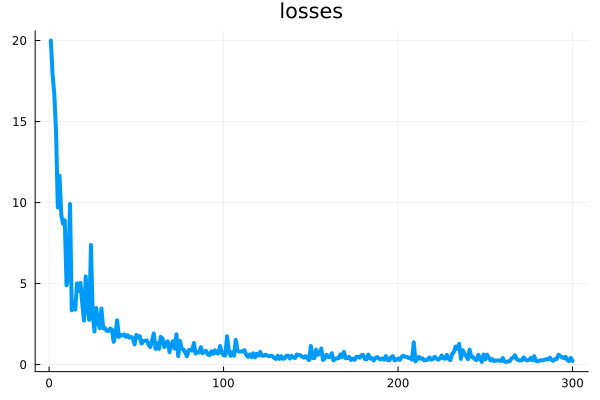

In [83]:
p = plot(loss_hist, title="losses", linewidth=4, legend=false)
savefig(p,"figures/losses.png")
display(p)